In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from davood_ml_functions import *
import geopandas as gpd
# from warnings import filterwarnings
# filterwarnings("ignore")

In [ ]:
# take the dataset to the memory
# path = "C:\Users\Davood\Desktop\Bootcamp\DivarEstate\Divar.csv"
path = ... # path to the main dataset
df = pd.read_csv(path , index_col = 0)

C:\Users\Davood\AppData\Local\Temp\ipykernel_22504\3948740109.py:2: DtypeWarning: Columns (11,27,29,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\Davood\Desktop\Bootcamp\DivarEstate\Divar.csv" , index_col = 0)


In [3]:
loc = df[["city_slug" , "location_latitude" , "location_longitude" , "cat2_slug"]]
loc.columns = ["city" , "lat" , "long" , "type"]
loc.index.name = "index"
loc.head()

,city,lat,long,type
index,,,,
0,karaj,35.811684,50.936600,temporary-rent
1,tehran,NaN,NaN,residential-sell
2,tehran,35.703865,51.373459,residential-rent
3,tehran,NaN,NaN,commercial-rent
4,mashhad,NaN,NaN,residential-sell


In [4]:
get_table_null_dtype(loc)

,null_percentage,dtype
column_name,,
lat,34.44,float64
long,34.44,float64
city,0.00,object
type,0.00,object


In [5]:
'''The difference is for the rounding done in the percentage of null values in the previous step.'''
loc = loc.dropna(subset = ["city"])
loc = loc.dropna(subset = ["type"])
print(loc.shape)

(999998, 4)


In [6]:
# loc.loc[: , "lat"] = loc.groupby("city")["lat"].transform(lambda x : x.fillna(x.mean()))
# loc.loc[: , "long"] = loc.groupby("city")["long"].transform(lambda x : x.fillna(x.mean()))

'''Replacing missing values with the mean is simple, but it creates a problem:
all the missing points get clustered at a single value (the mean),
making them hard to identify and potentially misleading.'''
for col in ["lat" , "long"]:
    new_values = []
    for city, group in loc.groupby("city"):
        filled = group[col].copy()
        valid = group[col][group[col].notna()]
        if len(valid) > 0:
            q_low = valid.quantile(0.48)
            q_high = valid.quantile(0.52)
            mask = filled.isna()
            filled.loc[mask] = np.random.uniform(low = q_low , high = q_high , size = mask.sum())
        new_values.append(filled)
    loc[col] = pd.concat(new_values).sort_index()

get_table_null_dtype(loc)

,null_percentage,dtype
column_name,,
city,0.0,object
lat,0.0,float64
long,0.0,float64
type,0.0,object


In [7]:
loc = loc.dropna()
print(loc.shape)

(999998, 4)


In [8]:
# eliminate points outside iran borders 
# load borders
iran = gpd.read_file("ir_states_boundaries_coordinates.geojson")
# # dissolve Iran borders into one polygon
iran_union = iran.dissolve()
# filter loc by keeping only points inside Iran
loc = loc[gpd.points_from_xy(loc['long'], loc['lat']).within(iran_union.geometry.iloc[0])]

In [9]:
# make categories a bit fancy
rename_dict = {
    "residential-sell" : "Residential Sell",
    "residential-rent" : "Residential Rent",
    "commercial-rent" : "Commercial Rent ",
    "commercial-sell" : "Commercial Sell",
    "temporary-rent" : "Temporary Rent",
    "real-estate-services" : "Real Estate Services"}
loc["type"] = loc["type"].replace(rename_dict)

In [10]:
I = loc.index.to_numpy()
full_range = np.arange(0 , 1000000)
missing = np.setdiff1d(full_range , I)
p_out = missing.shape[0] / full_range.shape[0] * 100
print(f"{round(p_out , 2)}% of the points are geographically outside of Iran.")
pd.DataFrame(missing , columns = ["index_out"]).to_csv("index_out.csv" , index = False)

0.18% of the points are geographically outside of Iran.


In [11]:
# convert loc to geoDataFrame
gdf_points = gpd.GeoDataFrame(
    loc,
    geometry = gpd.points_from_xy(loc['long'], loc['lat']),
    crs = "EPSG:4326")

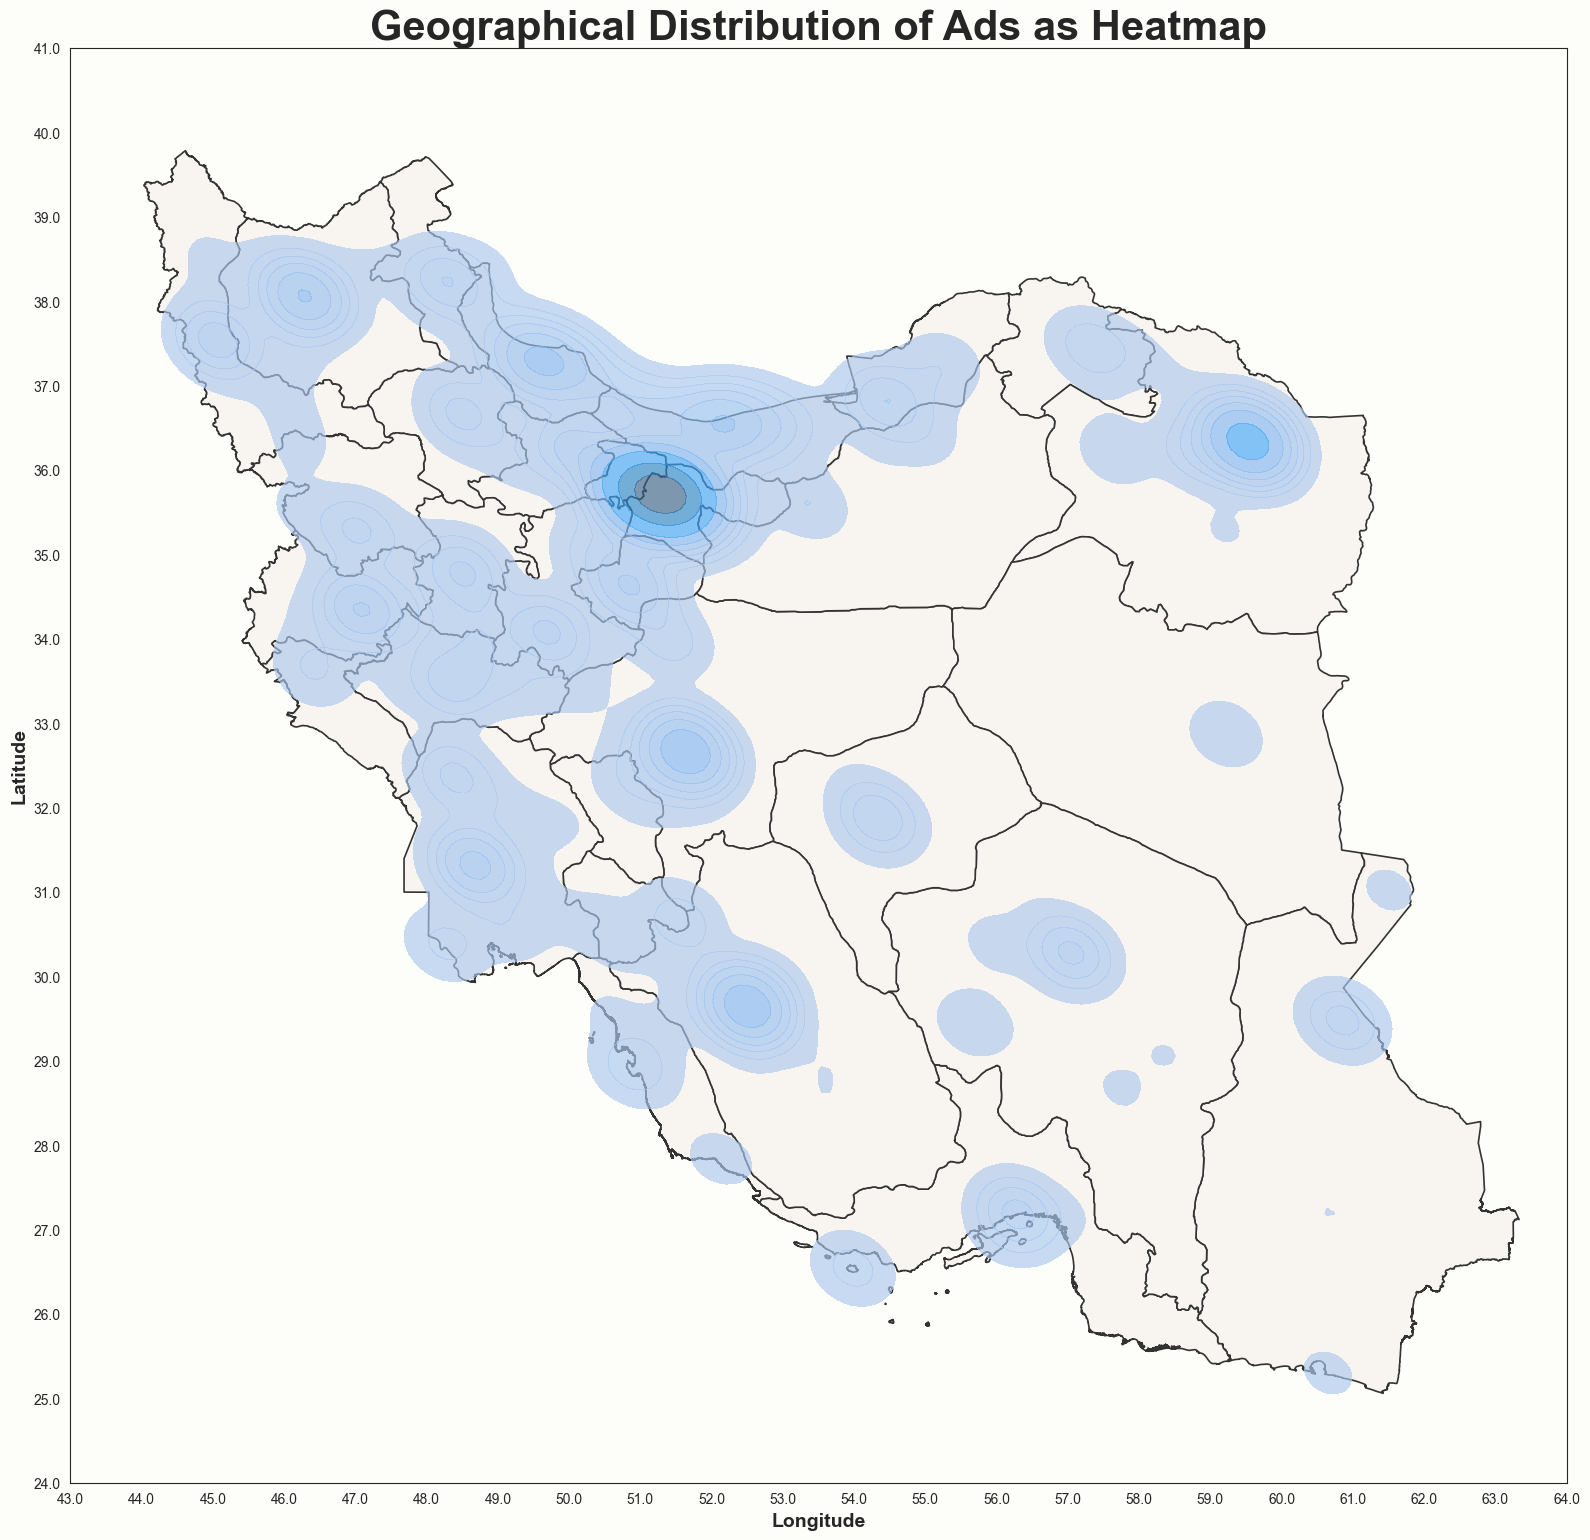

In [14]:
# initialize
sbn.set_style("white")
fig , ax = plt.subplots(figsize = (16 , 20))
fig.set_facecolor("#fdfdf9")
ax.set_facecolor("#fdfdf9")
# plot the borders
iran.plot(ax = ax , color = "#f8f4f0", edgecolor = "#333333", linewidth = 1.2)

# plot the heatmap
sbn.color_palette("YlOrBr", as_cmap=True)
sbn.kdeplot(x=loc['long'], y=loc['lat'], fill = True, cbar = False , alpha = 0.65)

# titles, etc.
ax.set_axis_off()
plt.title("Geographical Distribution of Ads as Heatmap", fontsize = 30 , weight = "bold")
ax.set_axis_on()
ax.set_xlabel("Longitude" , fontsize = 14 , weight = "bold")
ax.set_ylabel("Latitude" , fontsize = 14 , weight = "bold")
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x , _: f"{x:.1f}"))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y , _: f"{y:.1f}"))
ax.xaxis.set_major_locator(plt.MultipleLocator(1.0))
ax.yaxis.set_major_locator(plt.MultipleLocator(1.0))
ax.set_xbound(43 , 64)
ax.set_ybound(24 , 41)

# save and show
fig.savefig("geographical_distribution_of_ads_heatmap.png" , dpi = 400)
plt.tight_layout()
plt.show()

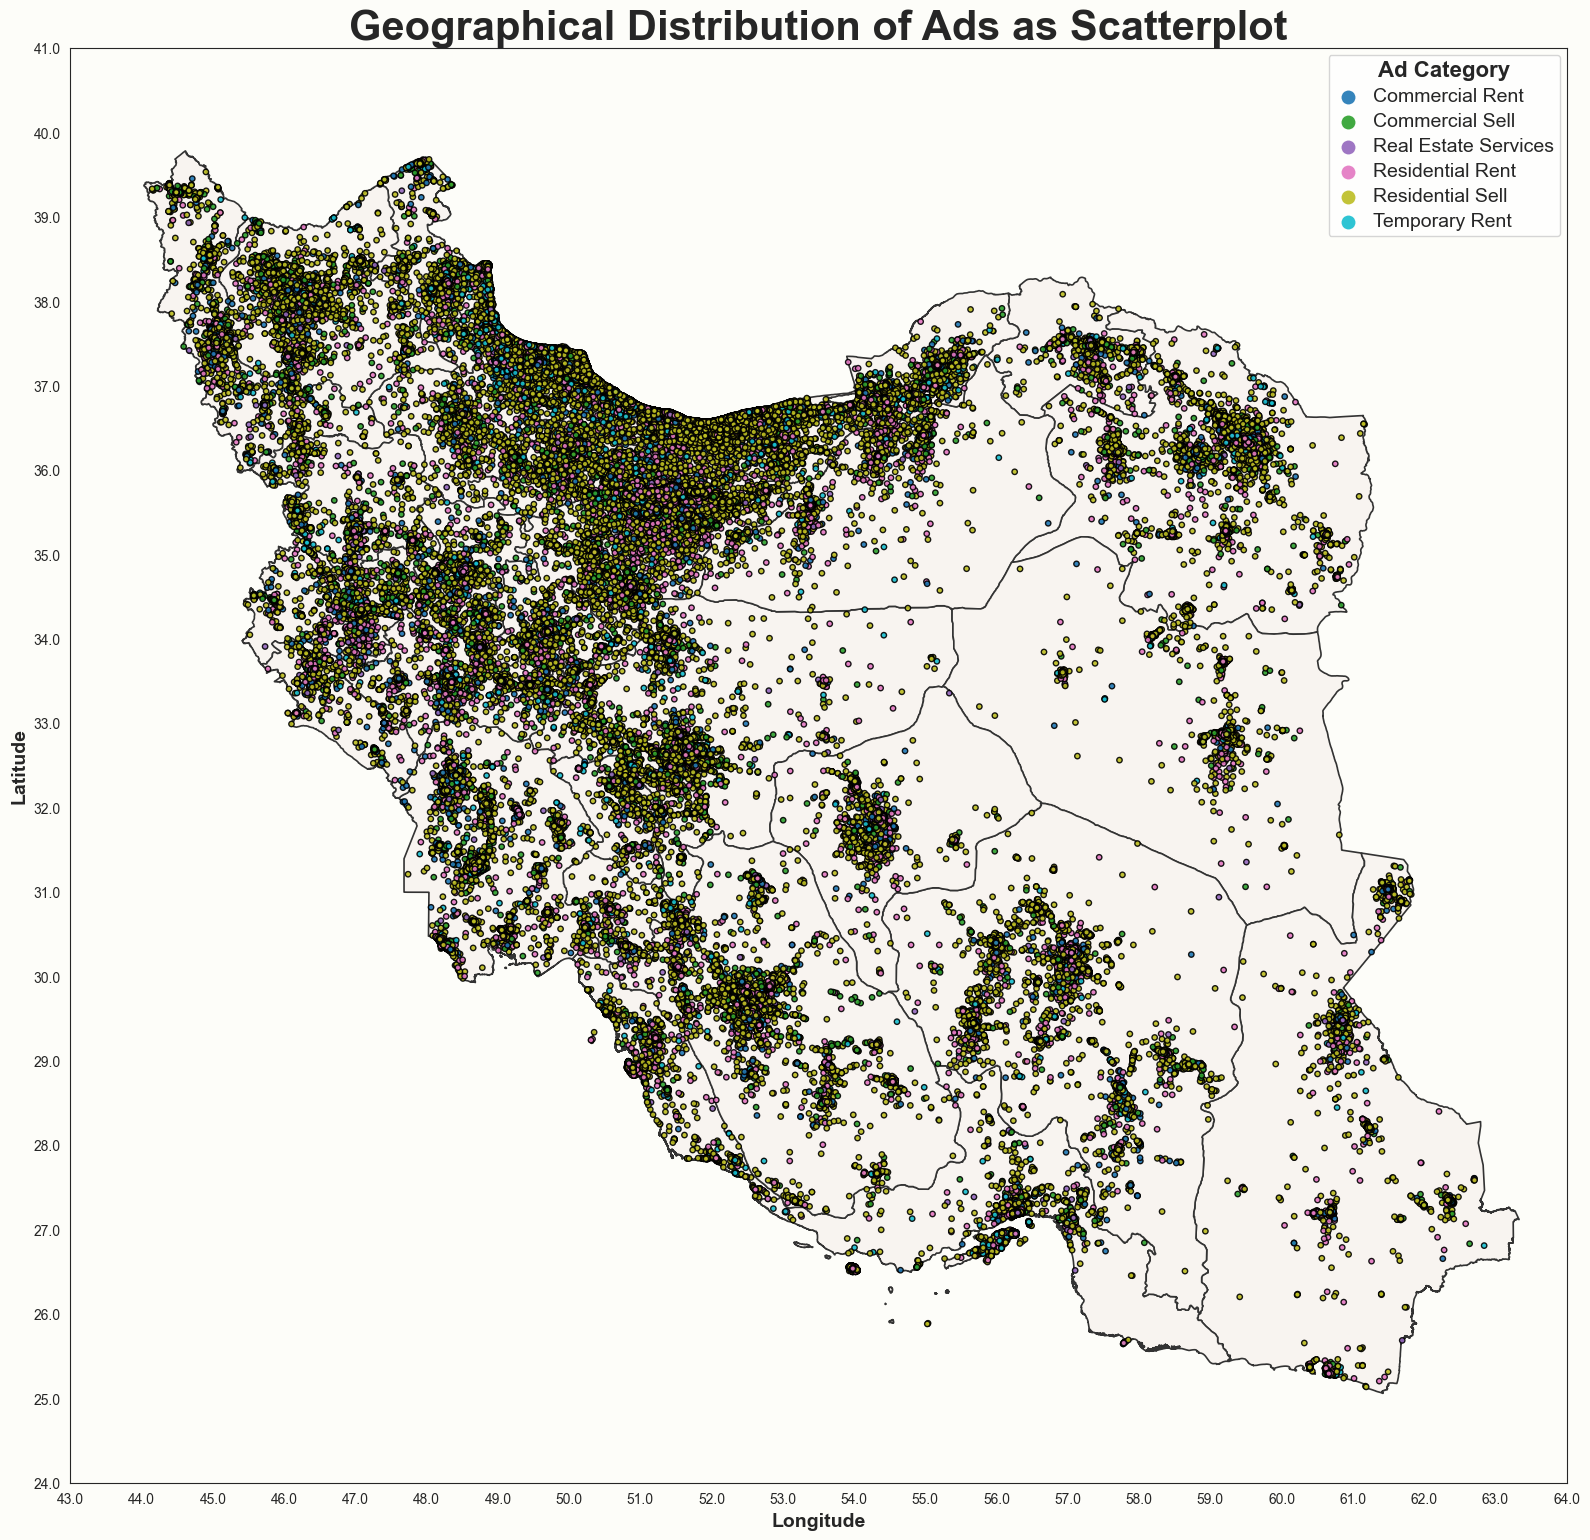

In [13]:
# initialize
sbn.set_style("white")
fig , ax = plt.subplots(figsize = (16 , 20))
fig.set_facecolor("#fdfdf9")
ax.set_facecolor("#fdfdf9")

# plot the borders
iran.plot(ax = ax , color = "#f8f4f0", edgecolor = "#333333", linewidth = 1.2)

# plot the points
gdf_points.plot(
    ax = ax,
    marker = "o",
    column = "type",
    categorical = True,
    legend = True,
    markersize = 15,
    alpha = 0.9,
    edgecolor = "black")

# legend
legend = ax.get_legend()
legend.set_title("Ad Category")
legend.get_title().set_fontweight("bold")
for text in legend.get_texts():
    text.set_fontsize(14)
legend.get_title().set_fontsize(16)

# titles, etc.
ax.set_axis_off()
plt.title("Geographical Distribution of Ads as Scatterplot", fontsize = 30 , weight = "bold")
ax.set_axis_on()
ax.set_xlabel("Longitude" , fontsize = 14 , weight = "bold")
ax.set_ylabel("Latitude" , fontsize = 14 , weight = "bold")
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x , _: f"{x:.1f}"))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y , _: f"{y:.1f}"))
ax.xaxis.set_major_locator(plt.MultipleLocator(1.0))
ax.yaxis.set_major_locator(plt.MultipleLocator(1.0))
ax.set_xbound(43 , 64)
ax.set_ybound(24 , 41)

# save and show
fig.savefig("geographical_distribution_of_ads_scatterplot.png" , dpi = 200)
plt.tight_layout()
plt.show()